In [1]:
print('Starting Evaluation')
print('(:......................................................................:)')

Starting Evaluation
(:......................................................................:)


In [2]:
#Loading and Parsing data
%run data_r.ipynb

ANCHORS = np.array([1.07709888,  1.78171903, 2.71054693,  5.12469308,10.47181473, 10.09646365, 5.48531347,  8.11011331]) 
LABELS  = ['aeroplane','bicycle','bird','boat','bottle', 'bus','car','cat','chair','cow','diningtable',
          'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

BATCH_SIZE        = 200
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13
TRUE_BOX_BUFFER   = 50
BOX               = int(len(ANCHORS)/2)
CLASS             = len(LABELS)
generator_config  = {'IMAGE_H': IMAGE_H,'IMAGE_W': IMAGE_W,'GRID_H': GRID_H,'GRID_W': GRID_W,
                     'LABELS': LABELS,'ANCHORS': ANCHORS,'BATCH_SIZE': BATCH_SIZE,'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,}


test_image_folder = './data/VOC2012/JPEGImages/'
test_annot_folder = './data/VOC2012/Annotations/'
path_to_weight    = './data/trained_weights.h5'
normalize = lambda x: x/255

test_image, seen_test_labels = parse_annotation(test_annot_folder,test_image_folder, labels=LABELS)


#Define YOLOv2
%run model_r.ipynb
model, true_boxes = define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS,trainable=False)


Using TensorFlow backend.


In [3]:
%run data_r.ipynb # for loading ImageReader
model.load_weights(path_to_weight)
IMAGE_H, IMAGE_W  = 416, 416
imageReader       = ImageReader(IMAGE_H=IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)

In [4]:
%run output_r.ipynb # find output boxes  and other stuff
# image_nms      = list(os.listdir(test_image_folder))
test_image, seen_test_labels = parse_annotation(test_annot_folder,test_image_folder, labels=LABELS)
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
imageReader    = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
X_test         = []
  
for img in test_image:
#     print(img)
#     _path    = os.path.join(test_image_folder,'..',img['filename'])
    out      = imageReader.fit(img['filename'])
    X_test.append(out) 
        
X_test = np.array(X_test)
## model
dummy_array    = np.zeros((len(X_test),1,1,1,TRUE_BOX_BUFFER,4))
y_pred         = model.predict([X_test,dummy_array])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:101: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [5]:
%run evaluate_support.ipynb


mAP = 0
images_size = []
shit = 0

summary = []
obj_thresh_list = [0.09, 0.1]#,0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75,0.8, 0.85, 0.9, 1.0]

iou_thresh_list = [0.1, 0.15]#, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7,0.75]

FP_list = np.zeros(20)
TP_list = np.zeros(20)
PR_list = []



for ob in obj_thresh_list:
    for io in iou_thresh_list:
        mAP = 0
        mAP_old = 0
        print('Starting ob,io: ', [ob, io])
        FP_list = np.zeros(20)
        TP_list = np.zeros(20)
        FN_list = np.zeros(20)
        for i in range(len(y_pred)):
            xtest = copy.deepcopy(X_test[i,:,:,:])
            xtest = np.expand_dims(xtest,0)

            dummy_array    = np.zeros((1,1,1,TRUE_BOX_BUFFER,4))
            y_pred_temp = copy.deepcopy(y_pred[i,:,:,:,:])
            netout_scale_temp   = copy.deepcopy(outputRescaler.fit(y_pred_temp))

            obj_threshold  = ob
            pred_high_tsh_tmp  = copy.deepcopy(find_high_class_probability_bbox(netout_scale_temp,obj_threshold))

            out_prediction         = copy.deepcopy(y_pred_temp)

            y_outputRescaler = copy.deepcopy(YOutputRescaler(ANCHORS=ANCHORS))

            out_prediction_scaled   = copy.deepcopy(y_outputRescaler.fit(out_prediction))

            ious_threshold = io

            test_image_proc = copy.deepcopy(test_image[i])
            percision,TP_list,FP_list,FN_list  = find_high_class_probability_bbox2(TP_list,FP_list,FN_list,out_prediction_scaled, obj_threshold, test_image_proc,pred_high_tsh_tmp,xtest,LABELS, ious_threshold)
            mAP_old = mAP_old + float(percision/len(y_pred))
                
    
        True_P = TP_list/(FP_list+TP_list)    
        True_Recall = TP_list/(TP_list + FN_list)
        
        mAP = np.nanmean(True_P)
        PR_list.append([True_Recall, True_P])
        print('[ob, io, mAP]: ', [ob, io, mAP])
        print('currently: TP = ',TP_list)
        print('currently: FP = ',FP_list)
        print('currently: FN = ', FN_list)
        print('[True_Recall, True_P] = ', [True_Recall, True_P])
        summary.append([ob, io, mAP])


print('PR_list: ',PR_list)

Starting ob,io:  [0.09, 0.1]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


[ob, io, mAP]:  [0.09, 0.1, 0.07017543859649122]
currently: TP =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 8. 0. 0. 0. 0. 0.]
currently: FP =  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. 49.  0.  0.  0.
  0.  0.]
currently: FN =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[True_Recall, True_P] =  [array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan,  1., nan, nan, nan, nan, nan]), array([       nan,        nan,        nan,        nan, 0.        ,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.14035088,
              nan,        nan,        nan,        nan,        nan])]
Starting ob,io:  [0.09, 0.15]
[ob, io, mAP]:  [0.09, 0.15, 0.07017543859649122]
currently: TP =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 8. 0. 0. 0. 0. 0.]
currently: FP =  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. 49.  0.  0.  0.
  0.  0.]
currently: FN =  [0. 0

In [6]:
print('summary= ', summary)

summary=  [[0.09, 0.1, 0.07017543859649122], [0.09, 0.15, 0.07017543859649122], [0.1, 0.1, 0.07272727272727272], [0.1, 0.15, 0.07272727272727272]]


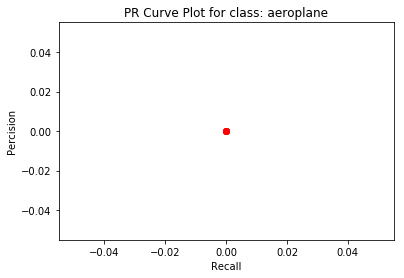

0.0


<Figure size 432x288 with 0 Axes>

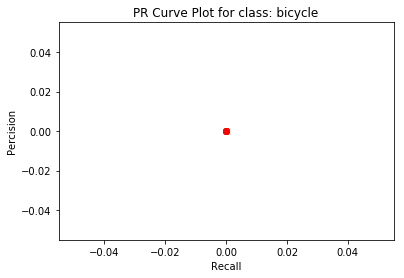

0.0


<Figure size 432x288 with 0 Axes>

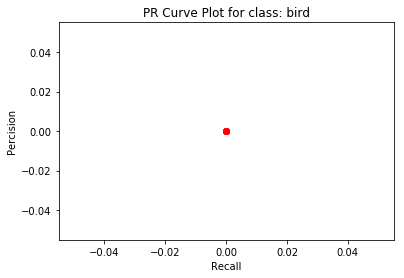

0.0


<Figure size 432x288 with 0 Axes>

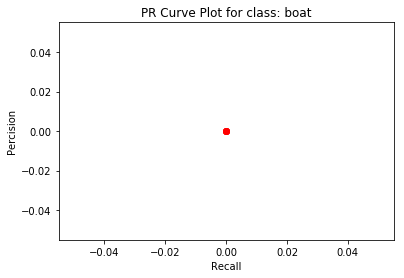

0.0


<Figure size 432x288 with 0 Axes>

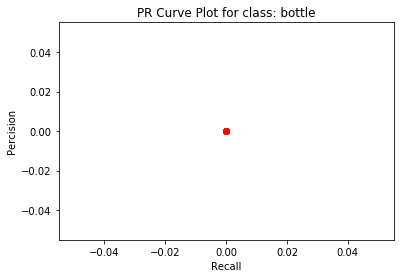

0.0


<Figure size 432x288 with 0 Axes>

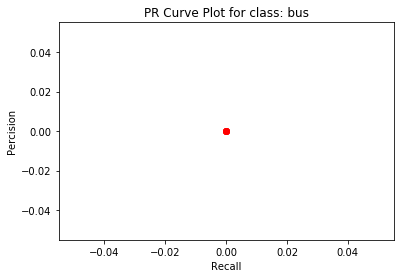

0.0


<Figure size 432x288 with 0 Axes>

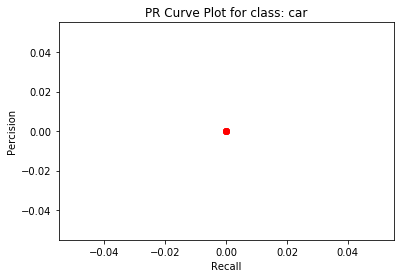

0.0


<Figure size 432x288 with 0 Axes>

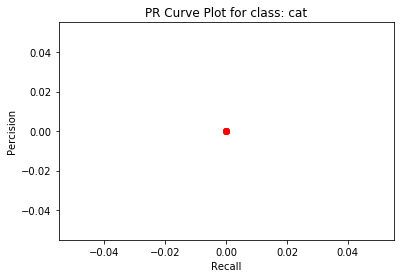

0.0


<Figure size 432x288 with 0 Axes>

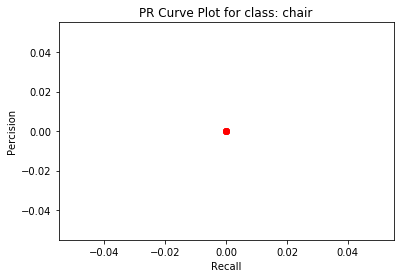

0.0


<Figure size 432x288 with 0 Axes>

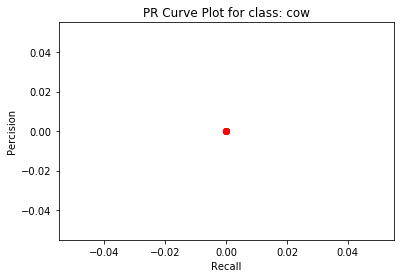

0.0


<Figure size 432x288 with 0 Axes>

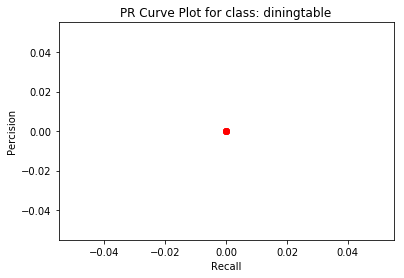

0.0


<Figure size 432x288 with 0 Axes>

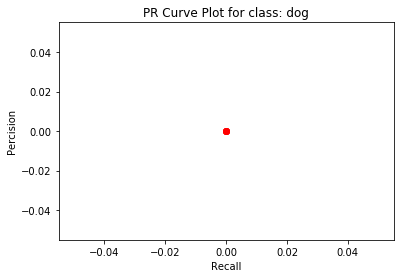

0.0


<Figure size 432x288 with 0 Axes>

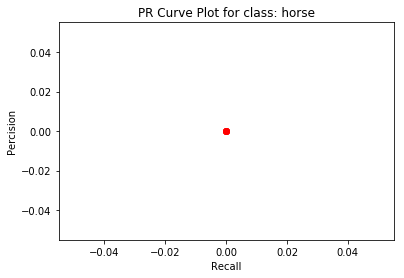

0.0


<Figure size 432x288 with 0 Axes>

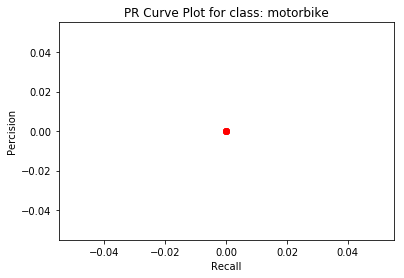

0.0


<Figure size 432x288 with 0 Axes>

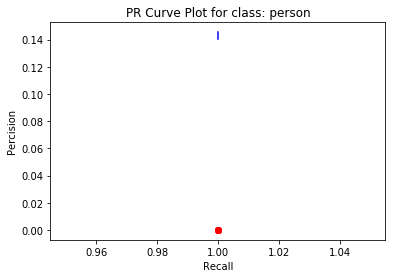

0.0


<Figure size 432x288 with 0 Axes>

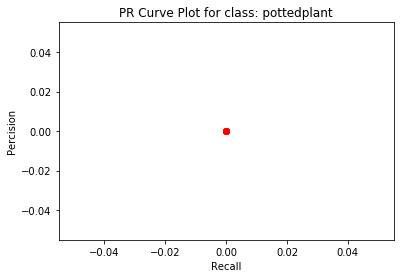

0.0


<Figure size 432x288 with 0 Axes>

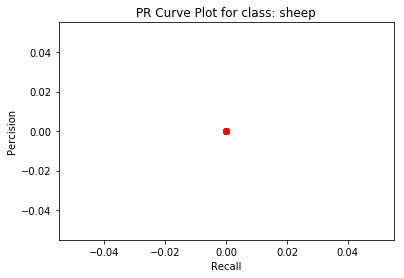

0.0


<Figure size 432x288 with 0 Axes>

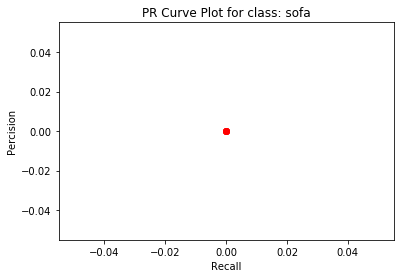

0.0


<Figure size 432x288 with 0 Axes>

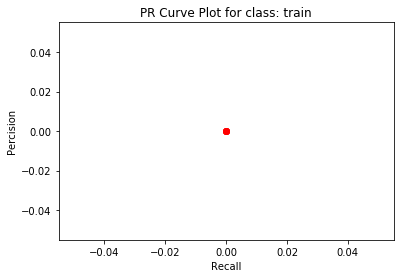

0.0


<Figure size 432x288 with 0 Axes>

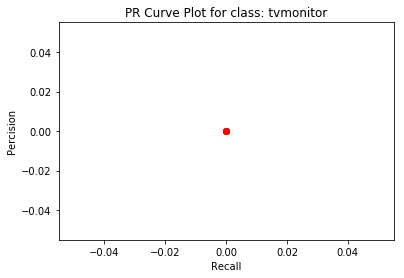

0.0


<Figure size 432x288 with 0 Axes>

In [7]:
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np
import math
integral_list = []

for cls in range(len(LABELS)):
    Rec = []
    Per = []

    for l in PR_list:
        Rec.append(l[0][cls])
        Per.append(l[1][cls])
    x = Rec
    y = Per

    for i in range(len(Rec)):
        if math.isnan(x[i]) or math.isnan(y[i]):
            x[i] = 0
            y[i] = 0
            
    x, y = zip(*sorted(zip(x, y)))

    fig = plt.figure()

    y_int = integrate.cumtrapz(y, x, initial=0)
    plt.plot(x, y_int, 'ro', x, y, 'b-')
    plt.title("PR Curve Plot for class: " + LABELS[cls])
    plt.xlabel('Recall')
    plt.ylabel('Percision')
    plt.show()
    plt.savefig('PR_plot_'+ LABELS[cls] +'.png')
    print(y_int[-1])
    integral_list.append(y_int[-1])

In [8]:
print('************************************************************************************************')
print('list of the Average Precisions forthe different classes: \n',integral_list)
print('\nmAP = ',np.mean(integral_list))
print('************************************************************************************************')


************************************************************************************************
list of the Average Precisions forthe different classes: 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

mAP =  0.0
************************************************************************************************


In [9]:
import matplotlib.pyplot as plt
import numpy as np
x = obj_thresh_list
y = iou_thresh_list
intensity = []
for i in range(len(x)):
    temp = []
    for k in range(len(y)):
        temp.append(summary[i*len(y)+k][2])
    intensity.append(temp)


2
<class 'list'>


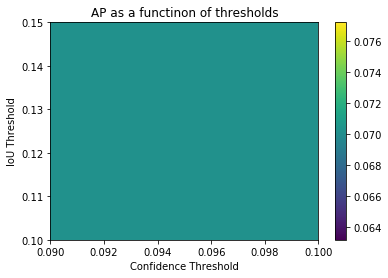

In [10]:
import matplotlib.pyplot as plt

#setup the 2D grid with Numpy
X, Y = np.meshgrid(x, y)
print(len(intensity))

#convert intensity (list of lists) to a numpy array for plotting
intensity2 = np.transpose(np.array(intensity))

print(type(intensity))

intensity2 = np.asarray(intensity2)

fig = plt.figure()
plt.pcolormesh(x, y, intensity2)
plt.colorbar() #need a colorbar to show the intensity scale
plt.title('AP as a functinon of thresholds')
plt.xlabel('Confidence Threshold')
plt.ylabel('IoU Threshold')
plt.show()
